# Look at accelerometer data 

Finding Zero velocity times by rail axis acceleration noise levels, making summary statistics for the noise levels across the whole day files.  Spot check graphs to see what works

In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'

#Standard cycle to make black and white images and dashed and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '-', '-', '-']))
plt.rc('axes', prop_cycle=default_cycler)
my_cmap = plt.get_cmap('gray')

In [2]:
#Extra Headers:
import os as os
import pywt as py
import statistics as st
import os as os
import random
import multiprocessing
from joblib import Parallel, delayed
import platform

from time import time as ti

In [3]:
import CoreFunctions as cf
from skimage.restoration import denoise_wavelet

## Choosing Platform
Working is beinging conducted on several computers, and author needs to be able to run code on all without rewriting..  This segment of determines which computer is being used, and sets the directories accordingly.

In [4]:
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

In [5]:
if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/image/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
elif Computer == 'PortLap':
    location = 'C:\\users\\dhendrickson\\Desktop\\AccelData\\'

In [6]:
if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/sciclone/scr10/dchendrickson01/Recordings2/'
    imageFolder = '/sciclone/scr10/dchendrickson01/Move3Dprint/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'Recordings2/'
elif Computer =='PortLap':
    rootfolder = location 
    folder = rootfolder + 'Recordings2\\'

In [7]:
files = os.listdir(folder)
files=files[39:41]

In [8]:
Saving = False
location = folder
Titles = True
Ledgends = True

f = 0


In [9]:
def RollingStdDev(RawData, SmoothData, RollSize = 25):
    StdDevs = []
    for i in range(RollSize):
        Diffs = RawData[0:i+1]-SmoothData[0:i+1]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / (i+1)
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)
    for i in range(len(RawData)-RollSize-1):
        j = i + RollSize
        Diffs = RawData[i:j]-SmoothData[i:j]
        Sqs = Diffs * Diffs
        Var = sum(Sqs) / RollSize
        StdDev = np.sqrt(Var)
        StdDevs.append(StdDev)  
    
    return StdDevs

def RollingSum(Data, Length = 100):
    RollSumStdDev = []
    for i in range(Length):
        RollSumStdDev.append(sum(Data[0:i+1]))
    for i in range(len(Data) - Length):
        RollSumStdDev.append(sum(Data[i:i+Length]))
    return RollSumStdDev

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02):
    SquelchSignal = np.ones(len(DataSet))

    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def getVelocity(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    Acceleration -= np.average(Acceleration)
    
    if len(Timestamps) == 1:
        dTime = np.ones(len(Acceleration),dtype=float) * Timestamps
    elif len(Timestamps) == len(Acceleration):
        dTime = np.zeros(len(Timestamps), dtype=float)
        dTime[0]=1
        for i in range(len(Timestamps)-1):
            j = i+1
            if Timestamps[j] > Timestamps[i]:
                dTime[j]=Timestamps[j]-Timestamps[i]
            else:
                dTime[j]=Timestamps[j]-Timestamps[i]+10000.0
        dTime /= 10000.0

    velocity[0] = Acceleration[0] * (dTime[0])

    for i in range(len(Acceleration)-1):
        j = i + 1
        if corrected ==2:
            if Squelch[j]==0:
                velocity[j]=0
            else:
                velocity[j] = velocity[i] + Acceleration[j] * dTime[j]                
        else:
            velocity[j] = velocity[i] + Acceleration[j] * dTime[j]

    if corrected == 1:
        PointVairance = velocity[-1:] / len(velocity)
        for i in range(len(velocity)):
            velocity[i] -=  PointVairance * i
    
    velocity *= 9.81

    return velocity

def MakeDTs(Seconds, Miliseconds):
    dts = np.zeros(len(Miliseconds), dtype=float)
    dts[0]=1
    for i in range(len(MiliSeconds)-1):
        j = i+1
        if Seconds[j]==Seconds[i]:
            dts[j]=Miliseconds[j]-Miliseconds[i]
        else:
            dts[j]=Miliseconds[j]-Miliseconds[i]+1000
    dts /= 10000
    return dts


In [10]:
#Smooth = cf.Smoothing(ODataSet[:,3],2) #,50)
def DeviationVelocity(file):
    if file[-3:] =='csv':
        ODataSet = np.genfromtxt(open(folder+file,'r'), delimiter=',',skip_header=0,missing_values=0,invalid_raise=False)
        SmoothX = denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SmoothY = denoise_wavelet(ODataSet[:,4], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SmoothZ = denoise_wavelet(ODataSet[:,5], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SmoothX -= np.average(SmoothX)
        SmoothY -= np.average(SmoothY)
        SmoothZ -= np.average(SmoothZ)
        StdDevsX = RollingStdDev(ODataSet[:,3],SmoothX)
        StdDevsX.append(0)
        StdDevsX = np.asarray(StdDevsX)
        SmoothDevX = denoise_wavelet(StdDevsX, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
        SquelchSignal = SquelchPattern(SmoothDevX, 2000, 0.03)
        #Velocity = getVelocity(ODataSet[:,3], ODataSet[:,2],SquelchSignal, 2)
        #Velocity = np.asarray(Velocity)
        MoveMatrix = np.matrix([SmoothX, SmoothY, SmoothZ])
        return [SquelchSignal,MoveMatrix,SmoothDevX,file[:-3]]
    else:
        pass

In [11]:
#files = fi2

In [12]:
# Maunally chooseing before and after tamping for same track

files = ['230103 recording3.csv','230104 recording3.csv','230105 recording3.csv','230106 recording3.csv',
         '230103 recording4.csv','230104 recording4.csv','230105 recording4.csv','230106 recording4.csv']

In [13]:
LoopFiles = 3
loops = int(len(files) / LoopFiles) 
if len(files)%LoopFiles != 0:
    loops += 1

In [14]:
SquelchSignal = []
RawData=[]
OrderedFileNames=[]

st = ti()

In [15]:
for k in range(loops):
    if k == loops -1:
        tfiles = files[k*LoopFiles:]
    else:
        tfiles = files[k*LoopFiles:(k+1)*LoopFiles]
    Results = Parallel(n_jobs=LoopFiles)(delayed(DeviationVelocity)(file) for file in tfiles)
    
    for i in range(len(Results)):       
        SquelchSignal.append(Results[i][0])
        RawData.append(np.matrix(Results[i][1]).T)
        OrderedFileNames.append(Results[i][2])
    print(k, np.shape(Results), (ti()-st)/60.0)
    


0 (3, 3) 8.494642881552378


/sciclone/home20/dchendrickson01/.conda/envs/simple/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


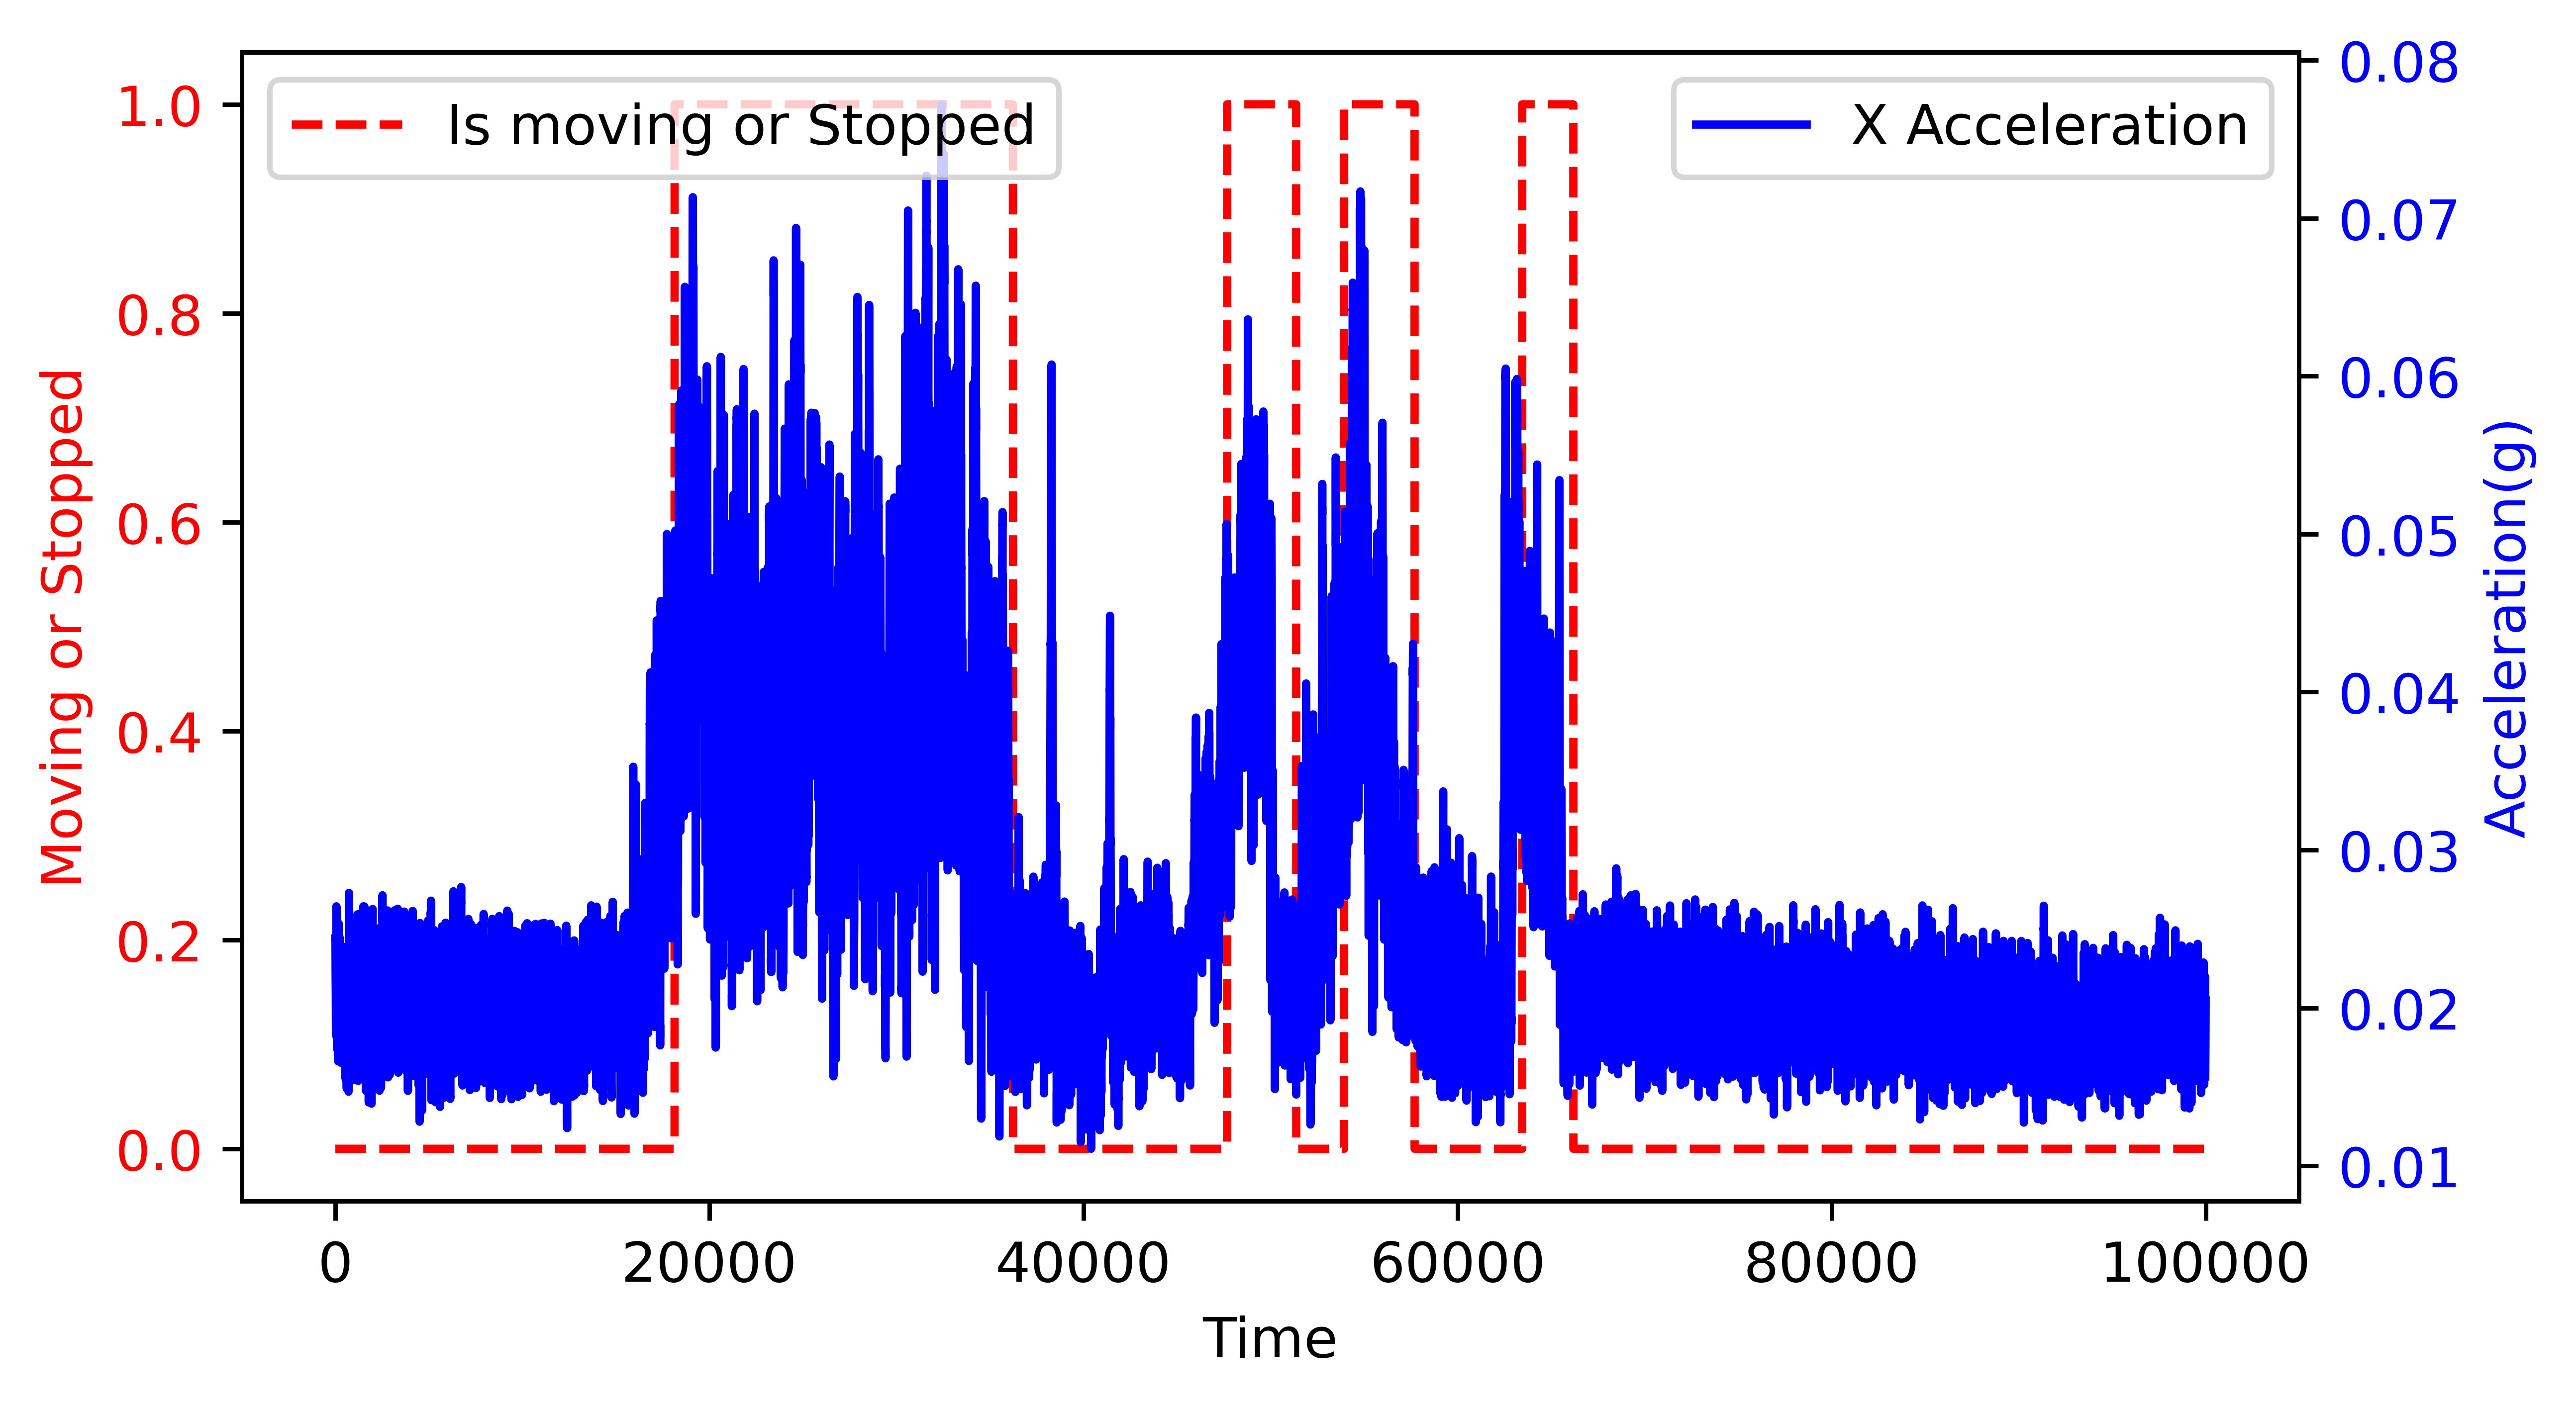

In [17]:
f=1

start = 1000000

fig, ax1 = plt.subplots(figsize=(6.67,3.75),dpi=800,linewidth=0.5) 

PlotLength = min(len(SquelchSignal[f]), np.shape(RawData[f])[0])
PlotLength = 100000

end = start + PlotLength

v = SquelchSignal[f][start:end]
sd = Results[f][2][start:end]

ax1.set_xlabel('Time') 
ax1.set_ylabel('Moving or Stopped', color = 'red') 
ax1.plot(range(PlotLength), v, color = 'red', linestyle = 'dashed', label='Is moving or Stopped' )
ax1.tick_params(axis ='y', labelcolor = 'red') 
#plt.ylim(-6,6)
legend_1 = ax1.legend(loc=2)
legend_1.remove()

# Adding Twin Axes

ax2 = ax1.twinx() 

ax2.set_ylabel('Acceleration(g)', color = 'blue') 
ax2.plot(range(PlotLength), sd, color = 'blue', label='X Acceleration') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
#plt.ylim(0.0,0.6)
ax2.legend(loc=1)
ax2.add_artist(legend_1)
# Show plot

plt.show()

In [18]:
def SepreateMovements(SquelchSignal, RawData):
    Moves= []
    Move = np.zeros((1,3), dtype=float)
    for j in range(len(SquelchSignal)-1):
        if SquelchSignal[j] == 1:
            try:
                Move = np.concatenate((Move, RawData[j,:]), axis=0)
            except:
                print(j)
            if SquelchSignal[j+1] == 0:
                #Move = np.matrix(Move)
                Moves.append(Move)
                Move = np.zeros((1,3), dtype=float)
                #Move[0,2]=0
    Moves.append(Move)
    return Moves
    

In [19]:
for i in range(len(RawData)):
    print(len(SquelchSignal[i]), len(RawData[i]))

13993236 13993236
24992885 24992885
25005066 25005066


In [20]:
Movements = Parallel(n_jobs=31)(delayed(SepreateMovements)(SquelchSignal[i], RawData[i])
                                       for i in range(len(RawData)))

In [21]:
Moves=[]
for Groups in Movements:
    for Move in Groups:
        Moves.append(Move)

In [22]:
len(Moves)

1628

In [23]:
del SquelchSignal
del RawData

In [24]:
def splitLong(Moves, maxLength = 4000, minLength = 1000):
    Xmoves = []
    for move in Moves:
        if np.shape(move)[0] > maxLength: 
            Xmoves.append(move[:int(len(move)/2),:])
            Xmoves.append(move[int(len(move)/2):,:])
        else:
            if np.shape(move)[0] < minLength:
                pass
            else:
                Xmoves.append(move)
    return Xmoves

def findMaxLength(Moves):
    maxLength = 0
    LongMove = 0
    for i in range(len(Moves)):
        if np.shape(Moves[i])[0] > maxLength: 
            maxLength =  np.shape(Moves[i])[0]
            LongMove = i
    return maxLength, LongMove

def findMinLength(Moves):
    minLength = 9999999
    SmallMove = 0
    for i in range(len(Moves)):
        if np.shape(Moves[i])[0] < minLength: 
            minLength =  np.shape(Moves[i])[0]
            SmallMove = i
    return minLength, SmallMove


In [25]:
longMove, MoveNumb = findMaxLength(Moves)

In [26]:
print(longMove, MoveNumb)

30148 901


In [27]:
MoveNum = MoveNumb

In [53]:
len(trys)

127

In [30]:
scales= 100
skips = 1
wvlt = 'coif'
trys = ['mexh','gaus2','dmey','gaus1','morl','cgau1','cgau2'] #'sym1','sym2','sym3','db1','db2']
wvlt = 'beta'

WvltFam = py.families()
Wvlts = []
for Fam in WvltFam:
    temp = py.wavelist(Fam)
    for wvlt in temp:
        Wvlts.append(wvlt)
        
trys = Wvlts

In [31]:
def MaxSpectrogram(Signal,i=0,Save=True):
    
    plt.specgram(Signal, Fs=6, cmap="rainbow")

    # Set the title of the plot, xlabel and ylabel
    # and display using show() function
    plt.title('Spectrogram Using matplotlib.pyplot.specgram() Method')
    plt.xlabel("DATA")
    plt.ylabel("TIME")
    if Save: plt.savefig(imageFolder+'specgram/Move '+str(i).zfill(4)+'.png')
    plt.show()
    
    return 0

In [32]:
Moves = splitLong(Moves, longMove+1)

In [48]:
f = 0
for i in range(len(Moves)):
    if f == 0:
        if abs(np.shape(Moves[i])[0] - 2000) < 50:
            print(i)
            f = 1
            MoveNum = i

np.shape(Moves[MoveNum][:,0])

0


(2001, 1)

In [49]:
print(findMinLength(Moves))

(1040, 43)


In [50]:
#wvlt = 'beta'
#FPimages = Parallel(n_jobs=60)(delayed(cf.makeMPFast)(Moves[i].T, wvlt, scales, skips,imageFolder+'org-beta/Move'+str(i).zfill(4)) for i in range(len(Moves)))

FPimages = Parallel(n_jobs=60)(delayed(cf.makeMPFast)(Moves[MoveNum].T, tri, scales, skips, imageFolder+'wvltTest/' + tri + '_LongMove') for tri in trys)

/sciclone/home20/dchendrickson01/Code/RMG_NDE_Disssertation/CoreFunctions.py:297: FutureWarning: Wavelets from the family shan, without parameters specified in the name are deprecated. The name should takethe form shanB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: shan1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/sciclone/home20/dchendrickson01/Code/RMG_NDE_Disssertation/CoreFunctions.py:297: FutureWarning: Wavelets of family fbsp, without parameters specified in the name are deprecated.  The name should take the form fbspM-B-C where M is the spline order and B, C are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
/sciclone/home20/dchendrickson01/Code/RMG_NDE_Disssertation/CoreFunctions.py:297: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name sho

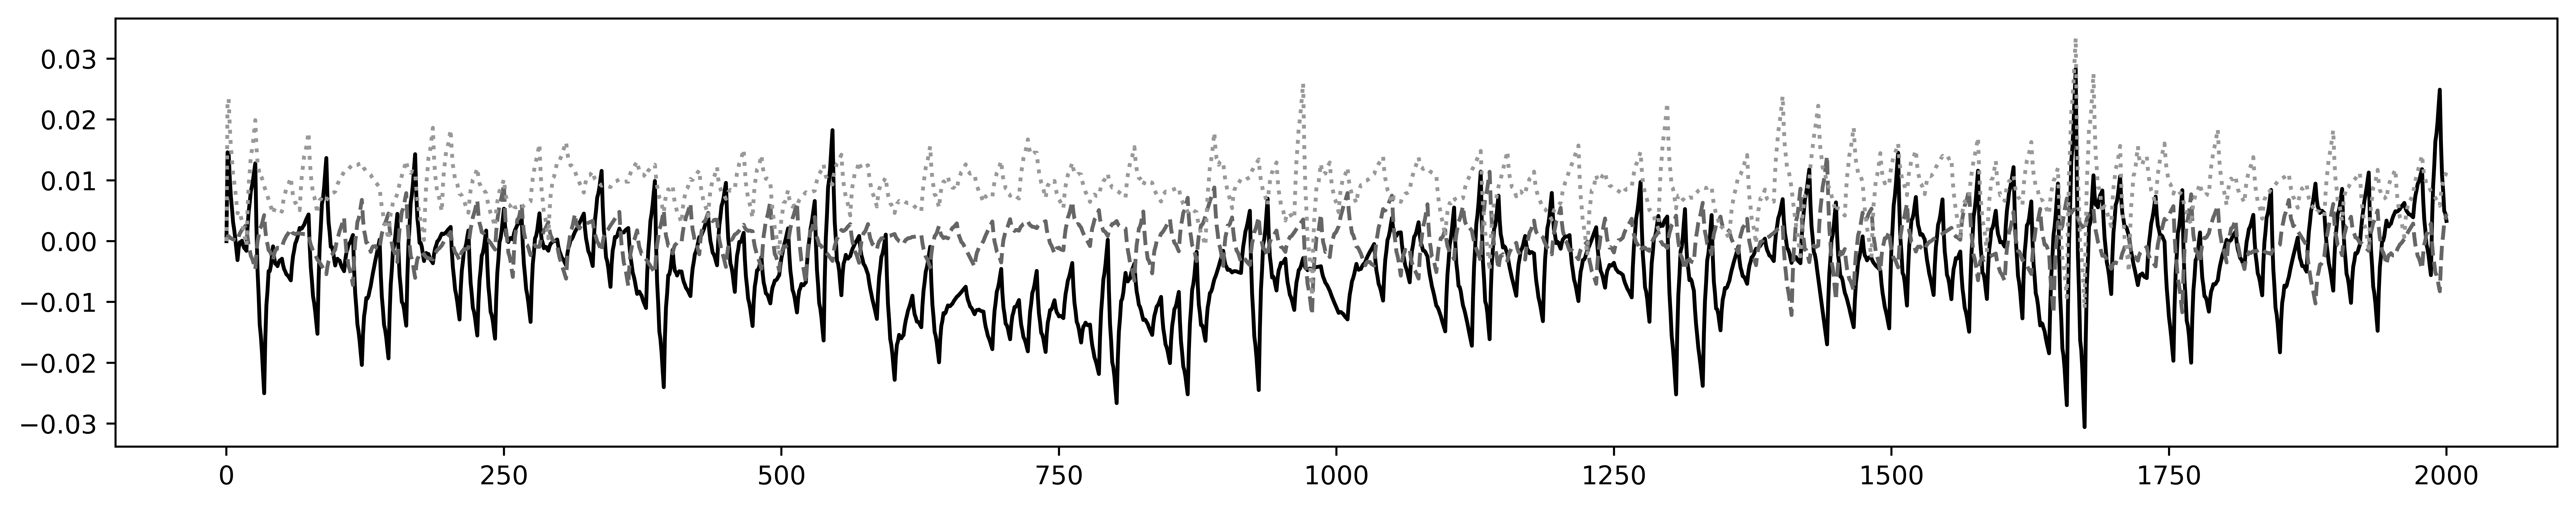

In [52]:
fig = plt.figure(figsize=(17,3), dpi=900)
plt.plot(Moves[MoveNum][:,0])
plt.plot(Moves[MoveNum][:,1])
plt.plot(Moves[MoveNum][:,2])
plt.show()

In [ ]:
maxDesiredLength = 4000

while findMaxLength(Moves)[0] > maxDesiredLength:
    Moves = splitLong(Moves, maxDesiredLength)

In [ ]:
spectrum, freqs, t, im = plt.specgram(np.asarray(Moves[MoveNum][:,0]), Fs=6, cmap="rainbow")

In [65]:
import scipy as ss
def MakeSpectrogramImages(data, title, something=300, nperseg = 512, novrelap=256):
    f, t, Szz = ss.signal.spectrogram(Moves[MoveNum][:,0].T,something,nperseg = nperseg, noverlap=novrelap)
    fig = plt.figure(figsize=(8,3), dpi=800)
    ax = plt.axes()
    ax.set_axis_off()
    plt.pcolormesh(t, f, Szz[0],cmap='gist_ncar')
    plt.savefig(imageFolder+'specgram/'+title+'.png',bbox_inches='tight', pad_inches=0)

In [66]:
FPimages = Parallel(n_jobs=60)(delayed(MakeSpectrogramImages)(Moves[i].T, 'Move'+str(i).zfill(4), 300, 512, 505) for i in range(len(Moves)))

In [3]:
x = [''  for x in range(10)]

In [4]:
x

['', '', '', '', '', '', '', '', '', '']